In [91]:
%matplotlib inline

### Install Python Packages

In [92]:
# include our Python packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm

In [93]:
torch.cuda.is_available()

True

### GPU Setup

In [94]:
print(torch.cuda.current_device())     # The ID of the current GPU.
print(torch.cuda.get_device_name(id))  # The name of the specified GPU, where id is an integer.
print(torch.cuda.device(id))           # The memory address of the specified GPU, where id is an integer.
print(torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
on_gpu = torch.cuda.is_available()
print(device)

0
NVIDIA GeForce RTX 3060 Ti
1
cuda


### Get MNIST Dataset and DataLoader

In [95]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Flatten operation (assuming you want to flatten the tensor along the spatial dimensions)
flatten = transforms.Lambda(lambda x: x.view(-1))

# Combine the original transforms with the flatten operation
combined_transform = transforms.Compose([
    transform,
    flatten,
])

train_dataset = MNIST(root='./data', train=True, transform=combined_transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

test_dataset = MNIST(root='./data', train=False, download=True, transform=combined_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=True)

#### View Images

In [96]:
# examples = enumerate(test_loader)
# batch_idx, (example_data, example_targets) = next(examples)

# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

### Create MLP

In [97]:
class MLP(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Linear(H3, H4),
            nn.ReLU(),
            nn.Linear(H4, D_out),
        )
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

### Select Model and Define HyperParameters

In [98]:
model = MLP(
    D_in = 28*28,
    H1 = 28*28,
    H2 = 512,
    H3 = 256,
    H4 = 128,
    D_out = 10,
)
# model = CNN()

print(model)

epochs = 25
learning_rate = 0.01
momentum = 0.3

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()

status_interval = 10

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Move Model and Data to GPU

In [99]:
if torch.cuda.is_available():
    print("Moving to Device")
    model.to(device)

Moving to Device


### Define Training Function

In [100]:
train_loss = []
train_count = []
test_loss = []
test_count = [i*len(train_loader.dataset) for i in range(epochs + 1)]

def train(epoch, dataloader, optimizer):
    model.train()

    print(f'Train Epoch: {epoch}')

    for batch, (data, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        if on_gpu:
            data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, label)
        # loss = F.nll_loss(output, label)
        loss.backward()

        optimizer.step()

        if batch % status_interval == 0:
            # print(f'Train Epoch: {epoch} [{batch * len(data)}/{len(dataloader.dataset)}] ({batch * 100 / len(dataloader):.0f}%)\tLoss: {loss.item():.6f}')
            train_loss.append(loss.item())
            train_count.append((batch*64) + ((epoch-1)*len(dataloader.dataset)))

    print(f'Loss: {loss.item():.6f}')

### Define Training Function

In [101]:
def test(dataloader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in dataloader:
            if on_gpu:
                data, label = data.to(device), label.to(device)
            output = model(data)
            loss += F.nll_loss(output, label, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()
    loss /= len(dataloader.dataset)
    test_loss.append(loss)
    print(f'\nTest Set: Avg. Loss: {loss:.4f}, Accuracy: {correct}/{len(dataloader.dataset)} ({100 * correct / len(dataloader.dataset):.0f}%)')

### Train Model

In [102]:
# test(dataloader=test_loader)
for epoch in range(0, epochs):
     print('==='*30)
     train(epoch=epoch+1, dataloader=train_loader, optimizer=optimizer)
     test(dataloader=test_loader)

Train Epoch: 1


100%|██████████| 1200/1200 [00:07<00:00, 161.20it/s]
c:\Users\rdash\anaconda3\envs\conda_gpu\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Loss: 0.572389

Test Set: Avg. Loss: -6.7881, Accuracy: 8794/10000 (88%)
Train Epoch: 2


100%|██████████| 1200/1200 [00:07<00:00, 162.77it/s]


Loss: 0.102691

Test Set: Avg. Loss: -7.6883, Accuracy: 9103/10000 (91%)
Train Epoch: 3


100%|██████████| 1200/1200 [00:07<00:00, 162.40it/s]


Loss: 0.157892

Test Set: Avg. Loss: -7.8825, Accuracy: 9338/10000 (93%)
Train Epoch: 4


100%|██████████| 1200/1200 [00:07<00:00, 164.23it/s]


Loss: 0.177801

Test Set: Avg. Loss: -8.5339, Accuracy: 9459/10000 (95%)
Train Epoch: 5


100%|██████████| 1200/1200 [00:07<00:00, 162.47it/s]


Loss: 0.285901

Test Set: Avg. Loss: -8.9754, Accuracy: 9507/10000 (95%)
Train Epoch: 6


100%|██████████| 1200/1200 [00:07<00:00, 162.72it/s]


Loss: 0.267685

Test Set: Avg. Loss: -9.8058, Accuracy: 9603/10000 (96%)
Train Epoch: 7


100%|██████████| 1200/1200 [00:07<00:00, 160.56it/s]


Loss: 0.039619

Test Set: Avg. Loss: -10.3112, Accuracy: 9663/10000 (97%)
Train Epoch: 8


100%|██████████| 1200/1200 [00:07<00:00, 162.70it/s]


Loss: 0.016724

Test Set: Avg. Loss: -10.5395, Accuracy: 9637/10000 (96%)
Train Epoch: 9


100%|██████████| 1200/1200 [00:07<00:00, 165.06it/s]


Loss: 0.079822

Test Set: Avg. Loss: -11.0212, Accuracy: 9645/10000 (96%)
Train Epoch: 10


100%|██████████| 1200/1200 [00:07<00:00, 163.60it/s]


Loss: 0.125569

Test Set: Avg. Loss: -11.7370, Accuracy: 9710/10000 (97%)
Train Epoch: 11


100%|██████████| 1200/1200 [00:07<00:00, 168.14it/s]


Loss: 0.008310

Test Set: Avg. Loss: -12.4660, Accuracy: 9708/10000 (97%)
Train Epoch: 12


100%|██████████| 1200/1200 [00:07<00:00, 167.28it/s]


Loss: 0.012117

Test Set: Avg. Loss: -12.3431, Accuracy: 9730/10000 (97%)
Train Epoch: 13


100%|██████████| 1200/1200 [00:07<00:00, 169.59it/s]


Loss: 0.038408

Test Set: Avg. Loss: -12.8014, Accuracy: 9730/10000 (97%)
Train Epoch: 14


100%|██████████| 1200/1200 [00:07<00:00, 168.46it/s]


Loss: 0.009278

Test Set: Avg. Loss: -13.2370, Accuracy: 9767/10000 (98%)
Train Epoch: 15


100%|██████████| 1200/1200 [00:07<00:00, 165.63it/s]


Loss: 0.128292

Test Set: Avg. Loss: -13.9657, Accuracy: 9769/10000 (98%)
Train Epoch: 16


100%|██████████| 1200/1200 [00:07<00:00, 164.42it/s]


Loss: 0.012768

Test Set: Avg. Loss: -14.6046, Accuracy: 9800/10000 (98%)
Train Epoch: 17


100%|██████████| 1200/1200 [00:07<00:00, 165.65it/s]


Loss: 0.134995

Test Set: Avg. Loss: -15.4882, Accuracy: 9766/10000 (98%)
Train Epoch: 18


100%|██████████| 1200/1200 [00:07<00:00, 170.88it/s]


Loss: 0.020511

Test Set: Avg. Loss: -15.4439, Accuracy: 9795/10000 (98%)
Train Epoch: 19


100%|██████████| 1200/1200 [00:07<00:00, 169.07it/s]


Loss: 0.006643

Test Set: Avg. Loss: -16.0326, Accuracy: 9759/10000 (98%)
Train Epoch: 20


100%|██████████| 1200/1200 [00:07<00:00, 167.21it/s]


Loss: 0.002455

Test Set: Avg. Loss: -16.7151, Accuracy: 9744/10000 (97%)
Train Epoch: 21


100%|██████████| 1200/1200 [00:07<00:00, 168.81it/s]


Loss: 0.004079

Test Set: Avg. Loss: -16.9425, Accuracy: 9789/10000 (98%)
Train Epoch: 22


100%|██████████| 1200/1200 [00:07<00:00, 168.92it/s]


Loss: 0.019228

Test Set: Avg. Loss: -17.9260, Accuracy: 9792/10000 (98%)
Train Epoch: 23


100%|██████████| 1200/1200 [00:07<00:00, 166.95it/s]


Loss: 0.007004

Test Set: Avg. Loss: -18.1027, Accuracy: 9797/10000 (98%)
Train Epoch: 24


100%|██████████| 1200/1200 [00:07<00:00, 167.68it/s]


Loss: 0.012443

Test Set: Avg. Loss: -18.8539, Accuracy: 9813/10000 (98%)
Train Epoch: 25


100%|██████████| 1200/1200 [00:07<00:00, 167.40it/s]


Loss: 0.024005

Test Set: Avg. Loss: -19.2556, Accuracy: 9808/10000 (98%)


### Test Model

In [103]:
test(test_loader)


Test Set: Avg. Loss: -19.2556, Accuracy: 9808/10000 (98%)


### Plot Results

Text(0, 0.5, 'negative log likelihood loss')

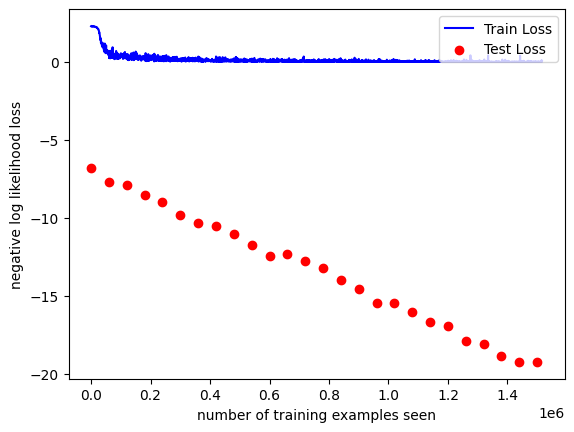

In [104]:
fig = plt.figure()
plt.plot(train_count, train_loss, color='blue')
plt.scatter(test_count, test_loss, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [105]:
# with torch.no_grad():
#   output = model(example_data)

# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Prediction: {}".format(
#     output.data.max(1, keepdim=True)[1][i].item()))
#   plt.xticks([])
#   plt.yticks([])